In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Choose which fields to use. 
def get_col_names(file_path):
  time_space = ['UTC_Start', 'G_LAT', 'G_LONG', 'G_ALT']
  names = pd.read_csv(file_path, skiprows=100, nrows=100).to_numpy()[:,0]
  col_names = time_space
  for item in names:
    if 'CAFS' in item and 'dnwFrac' not in item:  
      col_names.append(item) 
  return col_names

# Get the relevant data.    
def get_data(file_path, col_names):
  pre_rows = int((pd.read_csv(file_path, nrows=1, header=None))[0])
  relevant_data = pd.read_csv(file_path, skiprows=pre_rows-1, index_col=0, parse_dates=[0], usecols=col_names, na_values='-99999.0')
  return relevant_data

# Get the date and times.
def get_date_time(file_path, data):
  date = file_path[-16:-8]
  date = f'{date[0:4]}-{date[4:6]}-{date[6:8]}'
  data['UTC_Start_dt'] = pd.to_datetime(data.index, unit='s', origin=date)
  data.index = data['UTC_Start_dt']
  return data

In [1]:
# Tests on 1 file.
file_path = '/content/drive/MyDrive/Documents/AI4ER/PhD/Photolysis_data/ATom_MER10_Dataset.20210613/MER10_DC8_20160729_R35.ict'
'''
col_names = get_col_names(file_path)
print(len(col_names))
print(col_names)

data = get_data(file_path, col_names)
print(data.shape)
print(data[0:2])

data = get_date_time(file_path, data)
print(data[0:2])
'''

'\ncol_names = get_col_names(file_path)\nprint(len(col_names))\nprint(col_names)\n\ndata = get_data(file_path, col_names)\nprint(data.shape)\nprint(data[0:2])\n\ndata = get_date_time(file_path, data)\nprint(data[0:2])\n'

In [7]:
# Compile all the photolysis data.
folder_path = '/content/drive/MyDrive/Documents/AI4ER/PhD/Photolysis_data/ATom_MER10_Dataset.20210613'
all_files = glob.glob(folder_path + '/*.ict')
all_data = []
for each_file in all_files:
   col_names = get_col_names(each_file) 
   data = get_data(each_file, col_names)
   data = get_date_time(each_file, data)
   all_data.append(data)
all_data = pd.concat(all_data, axis=0)
all_data = all_data.drop(['UTC_Start_dt'], axis=1)

del col_names
del data


In [ ]:
# Make a .csv for easy viewing.
out_path = folder_path + '/photolysis_data.csv'
all_data.to_csv(out_path)

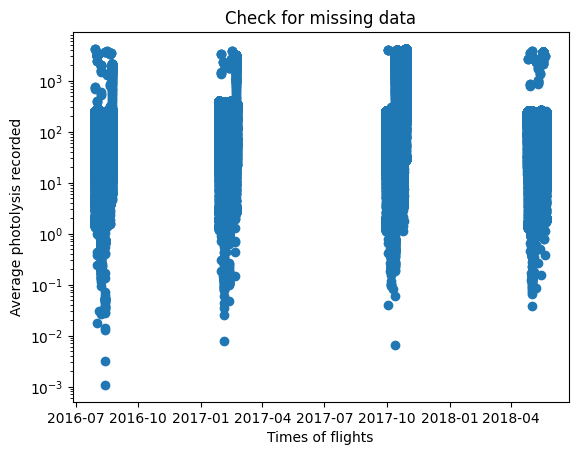

(149133, 49)


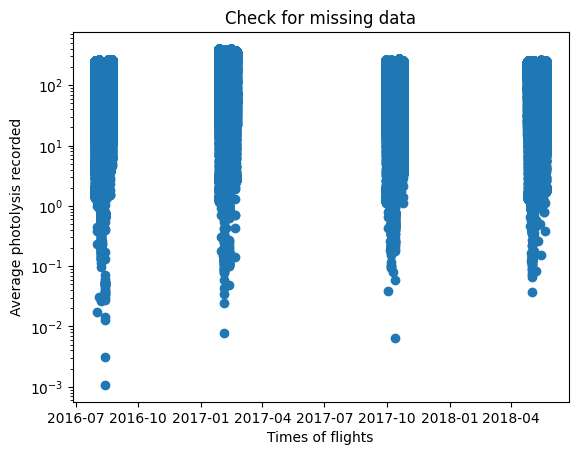

(138454, 49)
138454
There were 10679 entries with no photolysis.


In [8]:
def scatter(title, x, y, xlabel, ylabel):
  plt.figure()
  plt.yscale('log')
  plt.scatter(x, y)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# Show where there are no photolysis data.
title = 'Check for missing data'
xlabel = 'Times of flights'
ylabel = 'Average photolysis recorded'

x = all_data.index
y = all_data.mean(axis=1)
scatter(title, x, y, xlabel, ylabel)
print(all_data.shape)

# Remove entries with no photolysis data but keep entries with some recorded and some missing.
no_empty_data = all_data.dropna(axis='rows', thresh=4)
x = no_empty_data.index
y = no_empty_data.mean(axis=1)
scatter(title, x, y, xlabel, ylabel)
print(no_empty_data.shape)
print(len(no_empty_data.index))

num_empties = len(all_data.index) - len(no_empty_data.index)
print("There were {} entries with no photolysis.".format(num_empties))

In [35]:
# Remove empty entries from csv.
out_path = folder_path + '/photolysis_data.csv'
no_empty_data.to_csv(out_path)

In [33]:
# Check for outlying values.
# Separate spatial info from data for easier processing.
j_data = no_empty_data.drop(['G_LAT', 'G_LONG', 'G_ALT'], axis=1)
# Check for negative values.
print((j_data < 0).sum().sum(), "negative values \n")
#print(j_data[(j_data < 0).any(axis=1)])
print("The smallest numbers are:\n", j_data.min(axis=0))
# Since the negative numbers are so close to zero, I assume they are actually zero.
j_data[j_data < 0] = 0.0
print((j_data < 0).sum().sum(), "negative values \n")
# Check for unreasonably large numbers.
print("The largest numbers are:\n", j_data.max(axis=0))

150693 negative values 

The smallest numbers are:
 jO3_O2_O1D_CAFS                           -2.147373e-07
jNO2_NO_O3P_CAFS                          -9.255169e-07
jH2O2_OH_OH_CAFS                          -4.537855e-09
jNO3_NO_O2_CAFS                           -1.941065e-05
jNO3_NO2_O3P_CAFS                         -7.787087e-05
jN2O5_NO3_NO2_CAFS                        -2.134129e-08
jHNO2_OH_NO_CAFS                          -1.866287e-07
jHNO3_OH_NO2_CAFS                         -1.520387e-09
jHNO4_HO2_NO2_UvVisOnly_CAFS              -1.129243e-08
jCH2O_H_HCO_CAFS                          -2.479110e-08
jCH2O_H2_CO_CAFS                          -1.567912e-08
jCH3CHO_CH3_HCO_CAFS                      -2.913657e-08
jPropanal_CH2CH3_HCO_CAFS                 -4.620146e-08
jCH3OOH_CH3O_OH_CAFS                      -3.258291e-09
jMeONO2_CH3O_NO2_CAFS                     -1.858781e-09
jEthONO2_CH3CH2O_NO2_CAFS                 -2.858461e-09
jPAN_CH3COO2_NO2_CAFS                     -5.939511e

In [ ]:
del all_data
del no_empty_data
del j_data